In [1]:
# Task 2 notebook 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import cv2 
from gray_utils import rgb_to_gray_with_clahe
from skimage import color
from PIL import Image
import torchvision.models as models
import torch.nn.functional as F
import torchvision.models.segmentation as segmentation


In [3]:
class CIFARColorizationDataset(Dataset):
    def __init__(self,root_dir,train=True,augment=True):
        self.augment=augment
        
        self.base_dataset=torchvision.datasets.CIFAR10(
            root=root_dir,
            train=train,
            download=False,
            transform=None
        )
        
        self.aug_transform=transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15,interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2)
        ])
        self.to_Tensor=transforms.ToTensor()
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        # 1) Get the PIL image out of the torchvision CIFAR10 dataset
        pil_img, _ = self.base_dataset[idx]  # pil_img is 32×32 RGB (PIL Image)
        if self.augment:
            pil_img = self.aug_transform(pil_img)

        # 2) Convert to Tensor [3×32×32] in [0,1]
        img_rgb = self.to_Tensor(pil_img)

        # 3) Compute weighted+CLAHE grayscale via gray_utils
        gray = rgb_to_gray_with_clahe(img_rgb.unsqueeze(0)).squeeze(0)  # [1,32,32]

        # 4) Convert GT PIL→NumPy→Lab and normalize
        img_np = np.array(pil_img) / 255.0  # [32,32,3] ∈ [0,1]
        lab = color.rgb2lab(img_np.astype(np.float32))  # L∈[0,100], a,b∈[-128,127]
        L = lab[..., 0:1] / 100.0        # [32,32,1] ∈ [0,1]
        ab = lab[..., 1:3] / 128.0       # [32,32,2] ∈ [-1,1]

        L_t  = torch.from_numpy(L.astype(np.float32)).permute(2,0,1)   # [1,32,32]
        ab_t = torch.from_numpy(ab.astype(np.float32)).permute(2,0,1)  # [2,32,32]

        return {
            "gray":  gray,   # [1,32,32]
            "L_gt":  L_t,    # [1,32,32]
            "ab_gt": ab_t    # [2,32,32]
        }

In [4]:
"""
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader=DataLoader(dataset=train_dataset,batch_size=64,shuffle=True,num_workers=2)


test_dataset=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader=DataLoader(dataset=test_dataset,batch_size=64,shuffle=False,num_workers=2)"""

root_dir = './data'

full_train_ds= CIFARColorizationDataset(root_dir, train=True, augment=True)
train_len=int(0.9*len(full_train_ds))
val_len=len(full_train_ds)-train_len
train_ds,val_ds=random_split(full_train_ds, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=128,num_workers=0,shuffle=True,pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=128,num_workers=0,shuffle=False,pin_memory=True)

test_ds= CIFARColorizationDataset(root_dir, train=False, augment=False)
test_loader = DataLoader(test_ds, batch_size=128,num_workers=0,shuffle=False,pin_memory=True)
print(f"Train: {len(train_ds)} images, Val: {len(val_ds)} images, Test: {len(test_ds)} images.")

Train: 45000 images, Val: 5000 images, Test: 10000 images.


In [5]:
class UNet32(nn.Module):
    def __init__(self,base_ch=64):
        super(UNet32, self).__init__()
        
        #Encoder Stage 1: [1-64]
        self.enc1=nn.Sequential(
            nn.Conv2d(1, base_ch,   kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.pool1=nn.MaxPool2d(2)
        
        #Encoder Stage 2: [64-128]
        self.enc2=nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*2, base_ch*2, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        self.pool2=nn.MaxPool2d(2)
        
        #Encoder Stage 3: [128-256]
        self.enc3=nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch*4, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*4, base_ch*4, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True)
        )
        self.pool3=nn.MaxPool2d(2)
        
        #Bottleneck: [256-512]
        self.bottleneck=nn.Sequential(
            nn.Conv2d(base_ch*4, base_ch*8, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*8),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*8, base_ch*8, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*8),
            nn.ReLU(inplace=True)
        )
        
        #Decoder Stage 3: [512-256]
        self.up3=nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3=nn.Sequential(
            nn.Conv2d(base_ch*8, base_ch*4, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*4, base_ch*4, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True)
        )
        
        #Decoder Stage 2: [256-128]
        self.up2=nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2=nn.Sequential(
            nn.Conv2d(base_ch*4, base_ch*2, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*2, base_ch*2, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        
        #Decoder Stage 1: [128-64]
        self.up1=nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1=nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch, kernel_size=3,padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        
        #Final 1x1 conv -> 2 channels (a,b), then tanh to [-1,1]
        self.final=nn.Conv2d(base_ch, 2, kernel_size=1)
        self.tanh=nn.Tanh()
        
    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        b = self.bottleneck(p3)
        
        u3 = self.up3(b)
        cat3 = torch.cat((u3, e3), dim=1)
        d3 = self.dec3(cat3)
        
        u2 = self.up2(d3)
        cat2 = torch.cat((u2, e2), dim=1)
        d2 = self.dec2(cat2)
        
        u1 = self.up1(d2)
        cat1 = torch.cat((u1, e1), dim=1)
        d1 = self.dec1(cat1)
        
        out=self.tanh(self.final(d1))
        return out


In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU for training")
else:
    print("Using CPU for training")

model=UNet32(base_ch=64).to(device)
"""
model.load_state_dict(torch.load('colorization_model.pth'))
"""
criteria = nn.L1Loss()

vgg = models.vgg16(pretrained=True).features[:16].to(device)
for p in vgg.parameters():
    p.requires_grad = False
# Upsample from 32→96 (VGG works best on images ≥64×64)
up = nn.Upsample(scale_factor=3, mode="bilinear", align_corners=False)

optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60], gamma=0.5)










Using GPU for training


c:\Users\Amit Singh\Documents\Projects\nullClass_training-main\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Amit Singh\Documents\Projects\nullClass_training-main\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:


def lab_to_rgb_torch(lab_tensor):
    """
    Convert a Lab image tensor to RGB using skimage.color.lab2rgb.
    
    Parameters:
    - lab_tensor: Tensor of shape [B, 3, H, W] or [3, H, W]
                  L in [0,1], a,b in [-1,1]
    
    Returns:
    - rgb_tensor: Tensor of shape [B, 3, H, W] or [3, H, W] in [0,1]
    """
    single_image = False
    if lab_tensor.dim() == 3:
        lab_tensor = lab_tensor.unsqueeze(0)
        single_image = True

    lab_tensor = lab_tensor.clone().detach().cpu()

    L = lab_tensor[:, 0:1, :, :] * 100.0          # [0,100]
    a = lab_tensor[:, 1:2, :, :] * 128.0          # [-128,127]
    b = lab_tensor[:, 2:3, :, :] * 128.0

    lab = torch.cat([L, a, b], dim=1)             # [B,3,H,W]
    B, C, H, W = lab.shape

    rgb_imgs = []
    for i in range(B):
        lab_img = lab[i].permute(1, 2, 0).numpy()             # [H,W,3]
        
         # 🚨 SAFETY CLIPPING
        lab_img[:, :, 0] = np.clip(lab_img[:, :, 0], 0, 100)     # L ∈ [0,100]
        lab_img[:, :, 1] = np.clip(lab_img[:, :, 1], -128, 127)  # a ∈ [-128,127]
        lab_img[:, :, 2] = np.clip(lab_img[:, :, 2], -128, 127)  # b ∈ [-128,127]
        
        rgb_img = color.lab2rgb(lab_img.astype(np.float64))   # [H,W,3] in [0,1]
        rgb_imgs.append(torch.from_numpy(rgb_img).permute(2, 0, 1))  # [3,H,W]

    rgb_tensor = torch.stack(rgb_imgs)  # [B,3,H,W]

    return rgb_tensor.squeeze(0) if single_image else rgb_tensor


In [8]:
import time
dummy = torch.rand(128, 3, 32, 32).to("cuda")

start = time.time()
gray = rgb_to_gray_with_clahe(dummy)
end = time.time()

print(f"CLAHE batch time: {end - start:.2f} sec")


CLAHE batch time: 0.46 sec


In [9]:
"""
best_val= float('inf')
patience=15
epochs_since_improve=0
epochs=75

for epoch in range(1, epochs + 1):
    model.train()
    running_train=0.0
    
    for batch in train_loader:
        gray = batch['gray'].to(device)
        L_gt = batch['L_gt'].to(device)
        ab_gt = batch['ab_gt'].to(device)
        
        ab_pred=model(gray)
        loss_ab= criteria(ab_pred, ab_gt)
        
        L_pred    = gray * 100.0          # [B,1,32,32] → [0,100]
        ab_pred_s = ab_pred * 128.0       # [B,2,32,32] → [-128,128]
        lab_pred  = torch.cat([L_pred, ab_pred_s], dim=1)  # [B,3,32,32]
        rgb_pred32 = lab_to_rgb_torch(lab_pred)           # [B,3,32,32]
        rgb_pred96 = up(rgb_pred32)                        # [B,3,96,96]

        L_gt_full  = L_gt * 100.0                             # [B,1,32,32]
        ab_gt_s    = ab_gt * 128.0                            # [B,2,32,32]
        lab_gt     = torch.cat([L_gt_full, ab_gt_s], dim=1)   # [B,3,32,32]
        rgb_gt32   = lab_to_rgb_torch(lab_gt)                 # [B,3,32,32]
        rgb_gt96   = up(rgb_gt32)                             # [B,3,96,96]

        # Normalize for VGG
        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
        rgb_pred96 = rgb_pred96.to(device)
        rgb_gt96 = rgb_gt96.to(device)

        pred_norm = (rgb_pred96 - mean) / std
        gt_norm   = (rgb_gt96   - mean) / std
        feat_p    = vgg(pred_norm.float())
        feat_g    = vgg(gt_norm.float())
        loss_perc = F.l1_loss(feat_p, feat_g)

        # Total loss
        loss = loss_ab + 0.01 * loss_perc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train += loss.item()

    train_avg = running_train / len(train_loader)

    # 5.2C) Validation (only L1 on ab)
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for batch in val_loader:
            gray_v   = batch["gray"].to(device)
            ab_gt_v  = batch["ab_gt"].to(device)
            ab_pred_v = model(gray_v)
            running_val += criteria(ab_pred_v, ab_gt_v).item()
    val_avg = running_val / len(val_loader)

    print(f"Epoch {epoch:>2d}/{epochs}  |  Train L1(ab): {train_avg:.4f}  |  Val L1(ab): {val_avg:.4f}  |  LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping & checkpoint
    if val_avg < best_val:
        best_val = val_avg
        torch.save(model.state_dict(), "best_cifar_unet_clahe_lab.pth")
        epochs_since_improve = 0
    else:
        epochs_since_improve += 1
        if epochs_since_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

    scheduler.step()
    
"""

'\nbest_val= float(\'inf\')\npatience=15\nepochs_since_improve=0\nepochs=75\n\nfor epoch in range(1, epochs + 1):\n    model.train()\n    running_train=0.0\n\n    for batch in train_loader:\n        gray = batch[\'gray\'].to(device)\n        L_gt = batch[\'L_gt\'].to(device)\n        ab_gt = batch[\'ab_gt\'].to(device)\n\n        ab_pred=model(gray)\n        loss_ab= criteria(ab_pred, ab_gt)\n\n        L_pred    = gray * 100.0          # [B,1,32,32] → [0,100]\n        ab_pred_s = ab_pred * 128.0       # [B,2,32,32] → [-128,128]\n        lab_pred  = torch.cat([L_pred, ab_pred_s], dim=1)  # [B,3,32,32]\n        rgb_pred32 = lab_to_rgb_torch(lab_pred)           # [B,3,32,32]\n        rgb_pred96 = up(rgb_pred32)                        # [B,3,96,96]\n\n        L_gt_full  = L_gt * 100.0                             # [B,1,32,32]\n        ab_gt_s    = ab_gt * 128.0                            # [B,2,32,32]\n        lab_gt     = torch.cat([L_gt_full, ab_gt_s], dim=1)   # [B,3,32,32]\n        rgb

In [10]:
#torch.save(model.state_dict(), "best_cifar_unet_clahe_lab.pth")
model.load_state_dict(torch.load("best_cifar_unet_clahe_lab.pth", map_location=device,weights_only=True))
model.to(device)
model.eval()


UNet32(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [11]:
# Save model weights (best practice for deployment)
#torch.save(model.state_dict(), "colorization_vgg_clahe.pth")
# Save the full model (architecture + weights)
#torch.save(model, "colorization_full_vgg_clahe.pth")


In [12]:
def imshow(img):
  #Convert to NumPy
  if torch.is_tensor(img):
    npimg=img.cpu().numpy()
  else:
    npimg=img
  # Handle Channel Ordering
  if npimg.ndim == 3 and npimg.shape[0] in [1, 3]:
    npimg=np.transpose(npimg, (1, 2, 0))
  plt.imshow(npimg.squeeze(),cmap='gray' if npimg.ndim==2 or npimg.shape[-1]==1 else None)
  plt.axis('off')
    

def visualize_all_three(original_images,grayscale_images,colorized_images,n=5):

  fig=plt.figure(figsize=(3*n,4))
  for i in range(n):
    ax=plt.subplot(1,3*n,3*i+1)
    imshow(original_images[i])
    ax.set_title("Original")
    ax.axis("off")

    ax=plt.subplot(1,3*n,3*i + 2)
    gray_img= grayscale_images[i]
    if gray_img.ndim == 3 and gray_img.shape[0] == 1:
      gray_img=gray_img[0]
    imshow(gray_img)
    ax.set_title("Grayscale (CLAHE)")
    ax.axis("off")

    ax=plt.subplot(1,3*n,3*i + 3)
    imshow(colorized_images[i])
    ax.set_title("Colorized")
    ax.axis("off")

  plt.tight_layout()
  plt.show()

def torch_rgb_to_hsv(rgb):
  r,g,b=rgb[:,0,:,:],rgb[:,1,:,:],rgb[:,2,:,:]
  max_val, _=torch.max(rgb,dim=1)
  min_val,_=torch.min(rgb,dim=1)
  diff=max_val-min_val

  h = torch.zeros_like(r)
  mask=(max_val==r)&(g>=b)
  h[mask]=(g[mask]-b[mask])/diff[mask]
  mask=(max_val==r)&(g<b)
  h[mask]=(g[mask]-b[mask])/diff[mask] + 6.0
  mask=max_val==g
  h[mask]=(b[mask]-r[mask])/diff[mask] + 2.0
  mask=max_val==b
  h[mask]=(r[mask]-g[mask])/diff[mask] + 4.0
  h=h/6.0
  h[diff==0.0]=0.0

  s=torch.zeros_like(r)
  s[diff!=0.0]=diff[diff!=0.0]/max_val[diff!=0.0]

  v=max_val

  return torch.stack([h,s,v],dim=1)

In [13]:
def torch_hsv_to_rgb(hsv):
  h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
  i = (h * 6.0).floor()
  f = h * 6.0 - i
  p = v * (1.0 - s)
  q = v * (1.0 - s * f)
  t = v * (1.0 - s * (1.0 - f))

  i_mod = i % 6
  r = torch.zeros_like(h)
  g = torch.zeros_like(h)
  b = torch.zeros_like(h)

  r[i_mod == 0.0] = v[i_mod == 0.0]
  g[i_mod == 0.0] = t[i_mod == 0.0]
  b[i_mod == 0.0] = p[i_mod == 0.0]

  r[i_mod == 1.0] = q[i_mod == 1.0]
  g[i_mod == 1.0] = v[i_mod == 1.0]
  b[i_mod == 1.0] = p[i_mod == 1.0]

  r[i_mod == 2.0] = p[i_mod == 2.0]
  g[i_mod == 2.0] = v[i_mod == 2.0]
  b[i_mod == 2.0] = t[i_mod == 2.0]

  r[i_mod == 3.0] = p[i_mod == 3.0]
  g[i_mod == 3.0] = q[i_mod == 3.0]
  b[i_mod == 3.0] = v[i_mod == 3.0]

  r[i_mod == 4.0] = t[i_mod == 4.0]
  g[i_mod == 4.0] = p[i_mod == 4.0]
  b[i_mod == 4.0] = v[i_mod == 4.0]

  r[i_mod == 5.0] = v[i_mod == 5.0]
  g[i_mod == 5.0] = p[i_mod == 5.0]
  b[i_mod == 5.0] = q[i_mod == 5.0]

  return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images,saturation_factor=1.5,value_factor=1.05):
  images=images.clone()

  images_hsv=torch_rgb_to_hsv(images)

  images_hsv[:,1,:,:]=torch.clamp(images_hsv[:,1,:,:]*saturation_factor,0,1)
  images_hsv[:,2,:,:]=torch.clamp(images_hsv[:,2,:,:]*value_factor,0,1)

  color_exaggerated_images=torch_hsv_to_rgb(images_hsv)

  return color_exaggerated_images

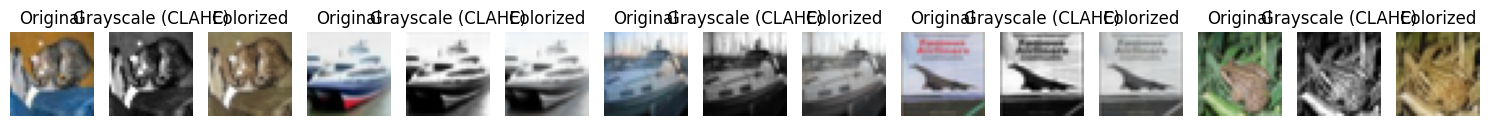

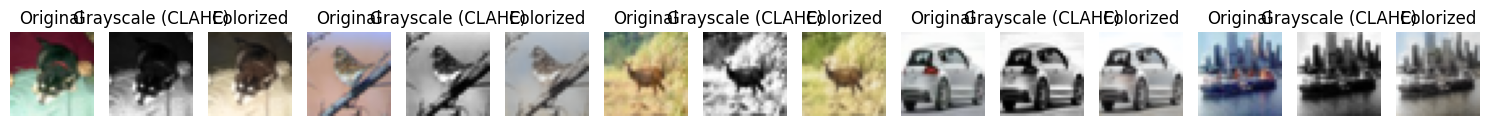

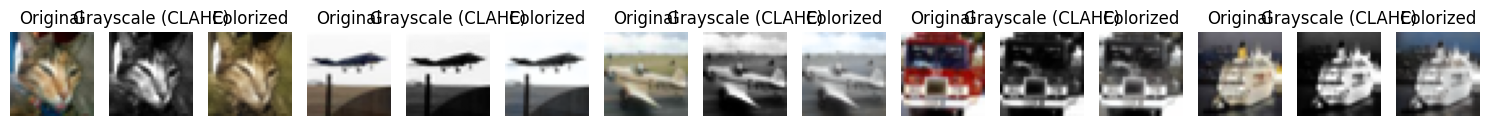

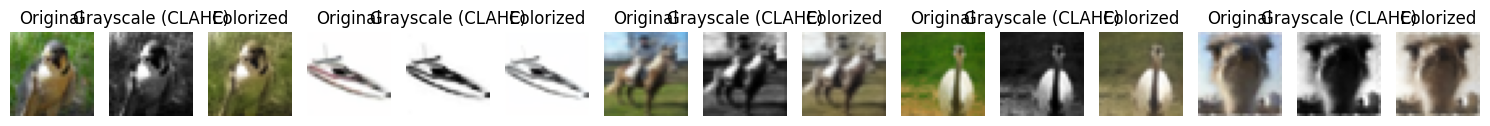

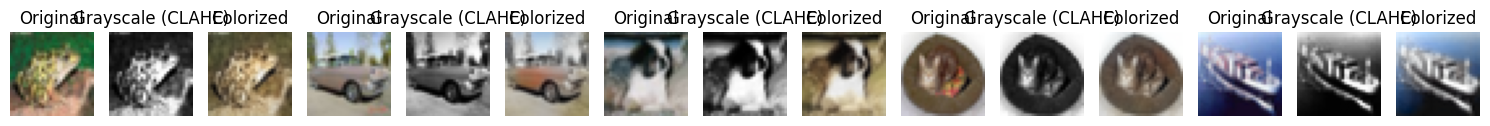

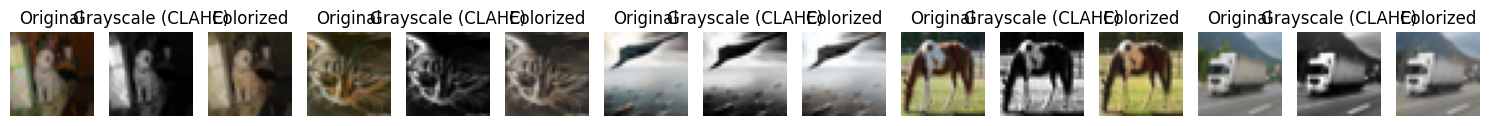

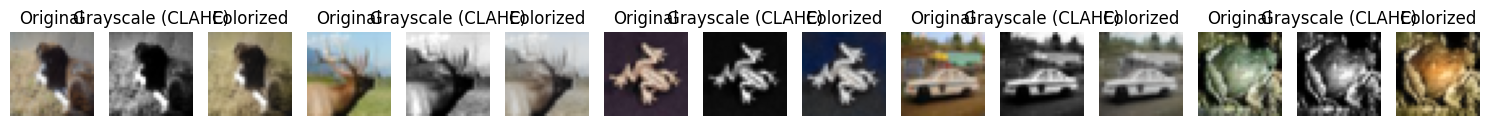

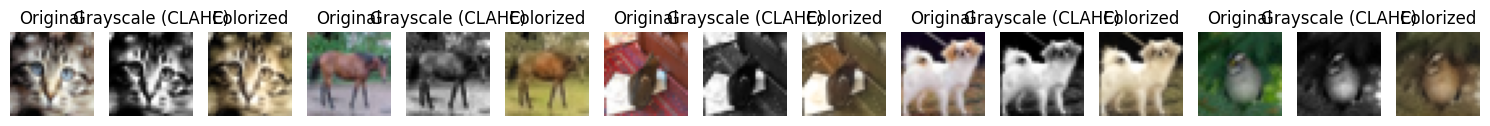

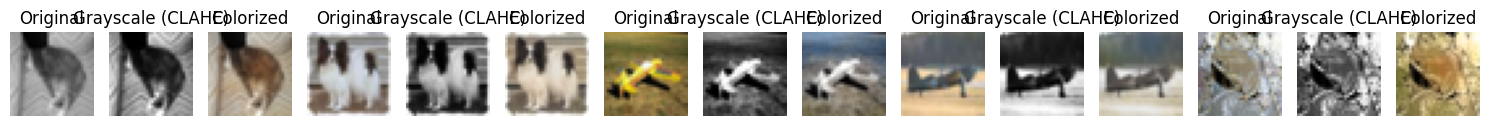

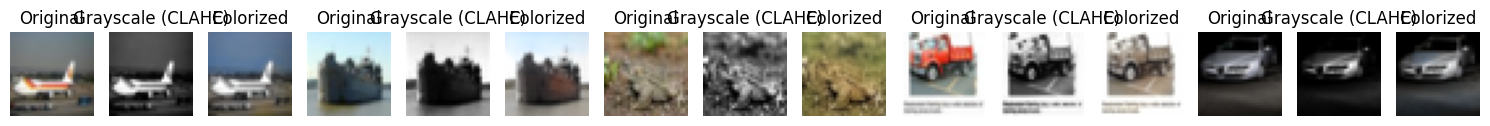

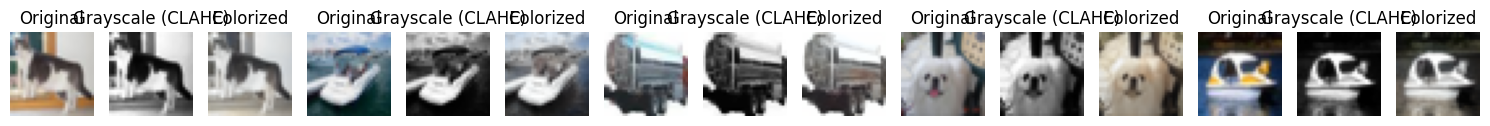

In [14]:
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        # 1) Move grayscale input to device and run model
        grayscale_images = batch["gray"].to(device)              # [B,1,32,32]
        pred_ab = model(grayscale_images)                        # [B,2,32,32]

        # 2) Get ground truth L channel
        L_gt = batch["L_gt"].to(device)                          # [B,1,32,32]
        #ab_gt = batch["ab_gt"].to(device)                        # [B,2,32,32]

        # 3) Concatenate L with predicted ab, and L with GT ab
        pred_lab = torch.cat([L_gt, pred_ab], dim=1).to(device)             # [B,3,32,32]
        gt_lab   = torch.cat([L_gt, batch["ab_gt"].to(device)], dim=1).to(device)      # [B,3,32,32]

        # 4) Convert Lab to RGB using your lab_to_rgb_torch function
        colorized_images_rgb = lab_to_rgb_torch(pred_lab)        # [B,3,32,32]
        original_images_rgb  = lab_to_rgb_torch(gt_lab)          # [B,3,32,32]

        # 5) Exaggerate the colorized images (optional flair 🌈)
        colorized_images_rgb = exaggerate_colors(colorized_images_rgb)

        # 6) Grayscale input for display (CPU + [B,32,32])
        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)

        # 7) Visualize all three views
        visualize_all_three(
            original_images=original_images_rgb,
            grayscale_images=grayscale_images_cpu,
            colorized_images=colorized_images_rgb,
            n=5
        )

        if i == 10:
            break


In [15]:
"""
# prompt: save the trained model

torch.save(model.state_dict(), 'colorization_model.pth')
"""

"\n# prompt: save the trained model\n\ntorch.save(model.state_dict(), 'colorization_model.pth')\n"

In [16]:
import os 

current_directory = os.getcwd()
print("Current working directory:", current_directory)
files=os.listdir(current_directory)
print("Files in the current directory:", files)


Current working directory: c:\Users\Amit Singh\Documents\Projects\nullClass_training-main
Files in the current directory: ['.venv', 'best_cifar_unet_clahe_lab.pth', 'best_cifar_unet_clahe_lab.zip', 'colorization_full_vgg_clahe.pth', 'colorization_full_vgg_clahe.zip', 'colorization_model.pth', 'colorization_model_updated.pth', 'colorization_vgg_clahe.pth', 'colorized_eiffeltower.jpeg', 'colorized_eiffeltower_updated.jpeg', 'data', 'eiffeltower.jpeg', 'eiffeltower_gray.jpeg', 'eiffeltower_gray_updated.jpeg', 'gray_utils.py', 'main copy 2.ipynb', 'main copy 2_temp.ipynb', 'main copy.ipynb', 'main.ipynb', 'main_task2_pyScript.py', '__pycache__']


In [17]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# 1) Load the Eiffel Tower image from disk, force RGB:
pil_img = Image.open('eiffeltower.jpeg').convert('RGB')

# 2) Define transform pipeline: Resize to 256×256 and ToTensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure dimensions are divisible by 8
    transforms.ToTensor()           # Converts to [3, H, W], floats in [0,1]
])

# 3) Convert PIL → tensor, then add batch dimension [1,3,H,W]:
img_tensor = transform(pil_img).unsqueeze(0).to(device)

# 4) Compute grayscale with CLAHE:
gray_tensor = rgb_to_gray_with_clahe(img_tensor)  # shape [1,1,H,W]

# 5) Run the model in eval mode:
model.eval()
with torch.no_grad():
    # 1) Get AB from model
    pred_ab = model(gray_tensor)                        # [1,2,H,W]

   # 2) Concatenate normalized L and ab—NO external scaling!
    lab_norm = torch.cat([gray_tensor, torch.clamp(pred_ab, -1.0, 1.0)], dim=1)  # [1,3,H,W]

    # 3) Convert Lab→RGB (handles clipping internally)
    rgb_pred = lab_to_rgb_torch(lab_norm)                # [1,3,H,W]

# 4) Now save with ToPILImage()
to_pil = transforms.ToPILImage()

gray_pil = to_pil(gray_tensor.squeeze(0).cpu())
gray_pil.save('eiffeltower_gray_updated.jpeg')

colorized_pil = to_pil(rgb_pred.squeeze(0).cpu())
colorized_pil.save('colorized_eiffeltower_updated.jpeg')

print("✅ Saved CLHE gray + properly reconstructed colorized images")

✅ Saved CLHE gray + properly reconstructed colorized images


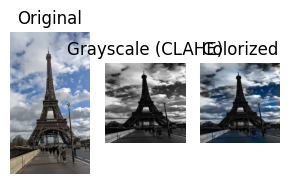

In [18]:
to_tensor = transforms.ToTensor()

# 1. Load saved images
original = to_tensor(Image.open("eiffeltower.jpeg").convert("RGB"))         # [3,H,W]
gray = to_tensor(Image.open("eiffeltower_gray_updated.jpeg").convert("L"))  # [1,H,W]
grayscale = gray.repeat(3, 1, 1)                                             # [3,H,W]
colorized = to_tensor(Image.open("colorized_eiffeltower_updated.jpeg").convert("RGB"))  # [3,H,W]

# 2. Batchify
original_batch = original.unsqueeze(0)     # [1,3,H,W]
grayscale_batch = grayscale.unsqueeze(0)   # [1,3,H,W]
colorized_batch = colorized.unsqueeze(0)   # [1,3,H,W]

# 3. Visualize
visualize_all_three(original_batch, grayscale_batch, colorized_batch, n=1)

In [24]:
def targeted_colorization_with_segmentation(pil_img_path, model, gray_fn, selected_classes, output_prefix="output"):
    device = next(model.parameters()).device

    # Load image
    pil_img = Image.open(pil_img_path).convert('RGB')

    # Resize + tensor
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    img_tensor = transform(pil_img).unsqueeze(0).to(device)

    # Grayscale
    gray_tensor = gray_fn(img_tensor)

    # Colorization
    model.eval()
    with torch.no_grad():
        pred_ab = model(gray_tensor)
        lab = torch.cat([gray_tensor, torch.clamp(pred_ab, -1.0, 1.0)], dim=1)
        rgb_pred = lab_to_rgb_torch(lab).to(device)

    # Segmentation
    seg_model = segmentation.deeplabv3_resnet50(pretrained=True).eval().to(device)
    seg_transform = transforms.Compose([
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    seg_input = seg_transform(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        seg_output = seg_model(seg_input)['out']
    seg_mask = torch.argmax(seg_output.squeeze(), dim=0).cpu().numpy()

    seg_mask_resized = cv2.resize(seg_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    seg_tensor = torch.from_numpy(seg_mask_resized).unsqueeze(0).unsqueeze(0).to(device)
    mask_tensor = torch.zeros_like(seg_tensor, dtype=torch.bool).to(device)
    for cls in selected_classes:
        mask_tensor |= (seg_tensor == cls)

    gray_3ch = gray_tensor.repeat(1, 3, 1, 1)
    final_tensor = torch.where(mask_tensor, rgb_pred, gray_3ch).to(device)

    # Save colorized output
    to_pil = transforms.ToPILImage()
    to_pil(final_tensor.squeeze(0).cpu().clamp(0,1)).save(f"{output_prefix}_targeted_colorized.jpeg")

    # Save segmentation mask
    seg_color = cv2.applyColorMap((seg_mask_resized * 10).astype(np.uint8), cv2.COLORMAP_JET)
    cv2.imwrite(f"{output_prefix}_segmentation_mask.jpeg", seg_color)

    print(f"✅ Saved: {output_prefix}_targeted_colorized.jpeg")
    print(f"✅ Saved: {output_prefix}_segmentation_mask.jpeg")

# Example call:
targeted_colorization_with_segmentation(
    pil_img_path="colorized_eiffeltower_updated.jpeg",
    model=model,
    gray_fn=rgb_to_gray_with_clahe,
    selected_classes=[21],
    output_prefix="eiffeltower"
)

✅ Saved: eiffeltower_targeted_colorized.jpeg
✅ Saved: eiffeltower_segmentation_mask.jpeg


In [26]:
import segment_anything as se

ModuleNotFoundError: No module named 'segment_anything'